In [1]:
import pandas as pd 
import numpy as np 
import gc 
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

load basic features 

In [3]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')
# df_test = pd.read_pickle('../input/feats/df_test_feat0.pkl')

Wall time: 136 ms


load text features

In [4]:
%%time 
with pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5') as store:
    print(store.keys())
    df_trn_text_feat  = store['df_trn_text_feat']
    df_test_text_feat = store['df_test_text_feat']

['/df_test_text_feat', '/df_trn_text_feat']
Wall time: 162 ms


load fm features 

In [12]:
# %%time 
# with pd.HDFStore('../input/feats/fm_uidx_rc_cnt_lat2.h5') as store:
#     print(store.keys())
#     df_fm_uidx_rc_cnt_lat2 = store['fm_uidx_rc_cnt_lat2']

['/fm_uidx_rc_cnt_lat2']
Wall time: 42 ms


In [12]:
# df_fm_uidx_rc_cnt_lat2.head().T

In [5]:
# df_train = df_train.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])
# df_test = df_test.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])

In [24]:
# df_train['cnt_by_uidx_rc'] = df_train['cnt'].astype('float16')
# df_train.drop('cnt',axis=1,inplace=True)

load interaction tsvd features

In [5]:
%%time 
with pd.HDFStore('../input/feats/feat2_trn_inter_svd.h5') as store:
    print(store.keys())
    df_trn_inter_svd = store['df_trn_inter_svd']
    df_test_inter_svd = store['df_test_inter_svd']

['/df_test_inter_svd', '/df_trn_inter_svd']
Wall time: 77.1 ms


combine features

In [6]:
%%time
# df_train = pd.concat([df_train, df_trn_text_feat ],axis=1)
df_train = pd.concat([df_train,df_trn_text_feat,df_trn_inter_svd], axis=1)

Wall time: 442 ms


In [7]:
selcols = list(df_train.columns)
drop_cols = ['deal_probability','activation_date','iid']
selcols = [col for col in selcols if col not in drop_cols]
X_train = df_train[selcols].copy()
y_train = df_train['deal_probability']

In [8]:
print('shape of X_train:',X_train.shape)

shape of X_train: (1503424, 49)


##### KFold

use built-in `lgb.cv`

In [11]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',    
    'max_depth': -1,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.05,
    'verbose': 20
}  

predictors = list(X_train.columns)


categorical = ['month','day','weekday',
               'param_1','param_2','param_3',
               'category_name','parent_category_name',
               'user_type']

dtrain = lgb.Dataset(X_train, label=y_train, feature_name=predictors, categorical_feature=categorical)
cv_results = lgb.cv(lgbm_params, dtrain, 
                    num_boost_round=10000, 
                    nfold=4,
                    stratified=False,
                    early_stopping_rounds=10,
                    verbose_eval= 100)
print('done')

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's rmse: 0.228278 + 0.000259203
[200]	cv_agg's rmse: 0.226613 + 0.000260928
[300]	cv_agg's rmse: 0.225932 + 0.000267815
[400]	cv_agg's rmse: 0.225564 + 0.000249602
[500]	cv_agg's rmse: 0.225257 + 0.000253508
[600]	cv_agg's rmse: 0.225024 + 0.00024957
[700]	cv_agg's rmse: 0.224833 + 0.000251103
[800]	cv_agg's rmse: 0.224674 + 0.000257615
[900]	cv_agg's rmse: 0.224565 + 0.000267663
[1000]	cv_agg's rmse: 0.224445 + 0.000258471
[1100]	cv_agg's rmse: 0.224366 + 0.000261898
[1200]	cv_agg's rmse: 0.224289 + 0.000274636
[1300]	cv_agg's rmse: 0.224218 + 0.000274773
[1400]	cv_agg's rmse: 0.224142 + 0.00027501
[1500]	cv_agg's rmse: 0.224087 + 0.000285468
[1600]	cv_agg's rmse: 0.224025 + 0.000285006
[1700]	cv_agg's rmse: 0.223984 + 0.00028696
[1800]	cv_agg's rmse: 0.223936 + 0.000290554
[1900]	cv_agg's rmse: 0.223898 + 0.000292542
[2000]	cv_agg's rmse: 0.223852 + 0.000292917
done


____

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [14]:
NFOLDS = 3
kf = KFold(n_splits=NFOLDS,random_state=0)
rmse_results = []
# def oof:
for nfold,(trn_idx, val_idx) in enumerate(kf.split(X_train)):
    x_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    x_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(x_trn,y_trn, feature_name=predictors, categorical_feature=categorical)
    dval   = lgb.Dataset(x_val,y_val, feature_name=predictors, categorical_feature=categorical)
    
    lgb_clf = lgb.train(lgbm_params,num_boost_round = 10000,
                        train_set = dtrain,
                        valid_sets = [dtrain, dval] ,                        
                        early_stopping_rounds=10,
                        verbose_eval= 100)                    
    y_pred = lgb_clf.predict(x_val)
    rmse = (mean_squared_error(y_pred,y_val))**0.5
    print('fold:{},\trmse:\t{:.4f}'.format(nfold,rmse))
    rmse_results.append(rmse)
    

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 0.227651	valid_1's rmse: 0.228072
[200]	training's rmse: 0.225162	valid_1's rmse: 0.226379
[300]	training's rmse: 0.223785	valid_1's rmse: 0.225717
[400]	training's rmse: 0.222781	valid_1's rmse: 0.225376
[500]	training's rmse: 0.221881	valid_1's rmse: 0.225123
[600]	training's rmse: 0.221078	valid_1's rmse: 0.224917
[700]	training's rmse: 0.220364	valid_1's rmse: 0.22478
[800]	training's rmse: 0.219666	valid_1's rmse: 0.224651
[900]	training's rmse: 0.218989	valid_1's rmse: 0.224524
Early stopping, best iteration is:
[979]	training's rmse: 0.218474	valid_1's rmse: 0.224436
fold:0,	rmse:	0.2244
Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 0.227554	valid_1's rmse: 0.228178
[200]	training's rmse: 0.22504	valid_1's rmse: 0.226572
[300]	training's rmse: 0.223677	valid_1's rmse: 0.225962
[400]	training's rmse: 0.222658	valid_1's rmse: 0.225601
[500]	training's rmse: 0

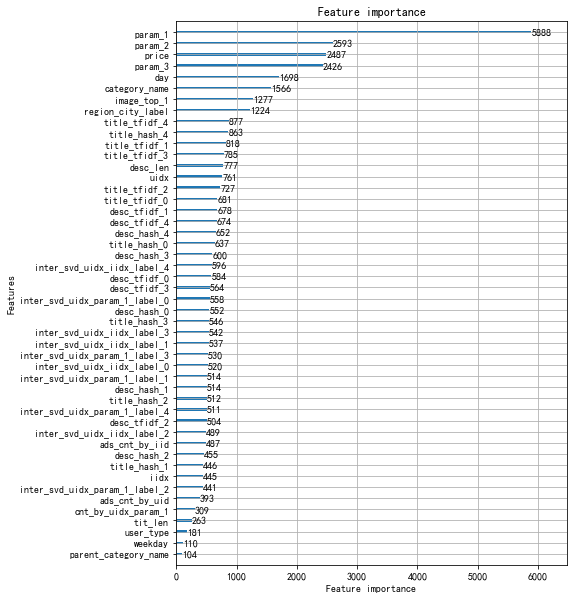

In [15]:
# feat_names = lgb_clf.feature_name()
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf,max_num_features=50, ax=ax)
# pd.DataFrame({'feat_idx':range(len(feat_names))})

____